In [ ]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t
import plotly.graph_objects as go
from math import sqrt
import matplotlib.pyplot as plt
import statistics
import plotly.express as px
import scipy.stats as stats


In [ ]:
df_bola_res = pd.read_csv('All_Qual_Mapping_Results_Bola.csv')
df_thru_res = pd.read_csv('All_Qual_Mapping_Results_Thru.csv')
df_Dynamic_res = pd.read_csv('All_Qual_Mapping_Results_Dynamic.csv')

In [ ]:
# df_bola_res = pd.read_csv('All_Qual_Mapping_Results_5sec.csv')
# df_thru_res = pd.read_csv('All_Qual_Mapping_Results_10s.csv')
# df_Dynamic_res = pd.read_csv('All_Qual_Mapping_Results_20s.csv')

In [ ]:
def split_dataframe(df):  # Split the dataframe into multiple dataframes based on the Time(sec) value
    dataframes = []
    split_indices = df[df['Time(sec)'].diff() < 0].index # Find the indices where the Time(sec) value decreases
    start_index = 0
    for idx in split_indices:
        df_split = df.iloc[start_index:idx]
        dataframes.append(df_split)
        start_index = idx
    dataframes.append(df.iloc[start_index:])
    return dataframes

In [ ]:

dataframes_bola = split_dataframe(df_bola_res)
dataframes_thru = split_dataframe(df_thru_res)
dataframes_dynamic = split_dataframe(df_Dynamic_res)

print("---"*20)
print(len(dataframes_bola))
print(len(dataframes_dynamic))
print(len(dataframes_thru))

def print_dataframes(df,name): # Print the dataframes
    print(f"---"*20)
    print(name)
    for i, df in enumerate(df):
        print(f'DataFrame {i + 1}')
        print(df)


------------------------------------------------------------
3
3
3


In [ ]:
print_dataframes(dataframes_bola,"bola")
print_dataframes(dataframes_dynamic,"dynamic")
print_dataframes(dataframes_thru,"thru")

def plot_confidence_interval(x, values, z=1.960, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

------------------------------------------------------------
bola
DataFrame 1
      Time(sec)  Quality
0         0.357  480x270
1         0.857  480x270
2         1.358  480x270
3         1.858  480x270
4         2.358  480x270
...         ...      ...
1613    776.298  480x270
1614    776.798  480x270
1615    777.298  480x270
1616    777.798  480x270
1617    778.291  480x270

[1618 rows x 2 columns]
DataFrame 2
      Time(sec)  Quality
1618      0.245  480x270
1619      0.745  480x270
1620      1.245  480x270
1621      1.745  480x270
1622      2.246  480x270
...         ...      ...
3169    742.683  960x540
3170    743.182  960x540
3171    743.683  960x540
3172    744.182  960x540
3173    744.427  960x540

[1556 rows x 2 columns]
DataFrame 3
      Time(sec)  Quality
3174      0.421  480x270
3175      0.922  480x270
3176      1.422  480x270
3177      1.922  480x270
3178      2.422  480x270
...         ...      ...
4788    778.352  480x270
4789    778.853  480x270
4790    779.353  480x27

In [ ]:
def calculate_confidence_interval(mean, std, n, confidence_level=0.95):
    degrees_of_freedom = n - 1
    t_score = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
    margin_of_error = t_score * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound

In [ ]:
def analyze_quality_changes(df):
    print(f"Total length of the video: {df['Time(sec)'].iloc[-1]} seconds")
    print(f"Total length of the video: {df['Time(sec)'].iloc[-1] / 60} minutes")
    max_minute = int(df['Time(sec)'].max() // 60)
    quality_changes_per_minute = {minute: 0 for minute in range(max_minute + 1)}

    previous_quality = None

    for i, row in df.iterrows():
        quality = row["Quality"]
        minute = int(row["Time(sec)"] // 60)

        if previous_quality is None:
            previous_quality = quality

        if quality != previous_quality:
            if minute not in quality_changes_per_minute:
                quality_changes_per_minute[minute] = 0
            quality_changes_per_minute[minute] += 1
            previous_quality = quality

    quality_changes_array = np.array(list(quality_changes_per_minute.values()))
    # non_zero_quality_changes_array = np.array([value for value in quality_changes_array if value > 0])

    mean = np.mean(quality_changes_array)
    std = np.std(quality_changes_array)
    min_value = np.min(quality_changes_array)
    max_value = np.max(quality_changes_array)

    print("Number of quality changes per minute:")
    for minute, count in sorted(quality_changes_per_minute.items()):
        print(f"Minute {minute}: {count} quality change(s)")

    print("Statistics for quality changes per minute:")
    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std}")
    print(f"Minimum: {min_value}")
    print(f"Maximum: {max_value}")

    # Calculate the confidence interval
    n = len(quality_changes_array)
    confidence_interval = calculate_confidence_interval(mean, std, n)

    # Print the confidence interval
    print(f"Confidence Interval: {confidence_interval}")
    print(f"Sample Size: {n}")

    sorted_quality_changes = sorted(quality_changes_per_minute.items())
    minutes, quality_changes_count = zip(*sorted_quality_changes)

    return mean, std, n, quality_changes_array


means, stds, ns= [], [], []
quality_chnages_bola, quality_chnages_dynamic, quality_chnages_thru = [], [], []

dataframe_sets = {
    'Bola': dataframes_bola,
    'Dynamic': dataframes_dynamic,
    'Thru': dataframes_thru
}

In [ ]:
for category, dataframes in dataframe_sets.items():
    for i, df in enumerate(dataframes):
        print("--" * 20)
        print(f"Analyzing {category} Video Test {i + 1}")
        mean, std, n, quality_change = analyze_quality_changes(df)
        means.append(mean)
        stds.append(std)
        ns.append(n)

        if category == 'Bola':
            quality_chnages_bola.append(quality_change)
        elif category == 'Dynamic':
            quality_chnages_dynamic.append(quality_change)
        elif category == 'Thru':
            quality_chnages_thru.append(quality_change)

print("--" * 20)
print(quality_chnages_bola)
print(quality_chnages_dynamic)
print(quality_chnages_thru)

----------------------------------------
Analyzing Bola Video Test 1
Total length of the video: 778.291 seconds
Total length of the video: 12.971516666666668 minutes
Number of quality changes per minute:
Minute 0: 5 quality change(s)
Minute 1: 6 quality change(s)
Minute 2: 4 quality change(s)
Minute 3: 6 quality change(s)
Minute 4: 7 quality change(s)
Minute 5: 3 quality change(s)
Minute 6: 9 quality change(s)
Minute 7: 4 quality change(s)
Minute 8: 5 quality change(s)
Minute 9: 4 quality change(s)
Minute 10: 4 quality change(s)
Minute 11: 0 quality change(s)
Minute 12: 5 quality change(s)
Statistics for quality changes per minute:
Mean: 4.769230769230769
Standard Deviation: 2.043896962397911
Minimum: 0
Maximum: 9
Confidence Interval: (3.5341161961868517, 6.004345342274687)
Sample Size: 13
----------------------------------------
Analyzing Bola Video Test 2
Total length of the video: 744.427 seconds
Total length of the video: 12.407116666666667 minutes
Number of quality changes per min

In [ ]:
def calculate_mean_std(quality_changes_list):
    flattened_array = np.concatenate(quality_changes_list)
    mean = np.mean(flattened_array)
    std = np.std(flattened_array)
    length = len(flattened_array)
    return mean, std , length

mean_std_bola = calculate_mean_std(quality_chnages_bola)
mean_std_dynamic = calculate_mean_std(quality_chnages_dynamic)
mean_std_thru = calculate_mean_std(quality_chnages_thru)

print("Mean , Length  and Standard Deviation for quality_changes_bola:", mean_std_bola)
print("Mean , Length Standard Deviation for quality_changes_dynamic:", mean_std_dynamic)
print("Mean ,  Length  Standard Deviation for quality_changes_thru:", mean_std_thru)

Mean , Length  and Standard Deviation for quality_changes_bola: (4.7, 2.451530134426253, 40)
Mean , Length Standard Deviation for quality_changes_dynamic: (0.0, 0.0, 33)
Mean ,  Length  Standard Deviation for quality_changes_thru: (0.0, 0.0, 33)


In [ ]:
def confidence_interval(data, confidence_level):

    if not 0 < confidence_level < 1:
        raise ValueError("Confidence level must be between 0 and 1.")

    data = np.array(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    margin_of_error = sem * stats.t.ppf((1 + confidence_level) / 2, len(data) - 1)

    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    percentage_error = (margin_of_error / mean) * 100

    # print (f"Confidence Interval: {mean} ±{margin_of_error} (±{percentage_error:.1f}%) [{lower_bound:.3f} – {upper_bound:.3f}]")
    # return (f"Confidence Interval: {mean} ±{margin_of_error} (±{percentage_error:.1f}%) [{lower_bound:.3f} – {upper_bound:.3f}]")
    return mean, margin_of_error, lower_bound, upper_bound

# flatteen each array
quality_chnages_bola = np.concatenate(quality_chnages_bola)
quality_chnages_dynamic = np.concatenate(quality_chnages_dynamic)
quality_chnages_thru = np.concatenate(quality_chnages_thru)

In [ ]:
print("Confidence Interval for Bola")
print(confidence_interval(quality_chnages_bola, 0.95))
print("Confidence Interval for Dynamic")
print(confidence_interval(quality_chnages_dynamic, 0.95))
print("Confidence Interval for Thru")
print(confidence_interval(quality_chnages_thru, 0.95))

f_stats, p_value = stats.f_oneway(quality_chnages_bola, quality_chnages_dynamic, quality_chnages_thru)
print("F-Statistics:", f_stats)
print("P-Value:", p_value)

if p_value > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

Confidence Interval for Bola
(4.7, 0.7940255103395565, 3.905974489660444, 5.494025510339557)
Confidence Interval for Dynamic
(0.0, 0.0, 0.0, 0.0)
Confidence Interval for Thru
(0.0, 0.0, 0.0, 0.0)
F-Statistics: 117.86002888267976
P-Value: 2.3676088965258624e-27
Probably different distributions


<ipython-input-10-2db56048d5a1>:13: RuntimeWarning: invalid value encountered in double_scalars
  percentage_error = (margin_of_error / mean) * 100


In [ ]:
# CODE NOTE 

# def plot_confidence_intervals(x, values, color='#2187bb', horizontal_line_width=0.25):
#     mean, margin_of_error, lower_bound, upper_bound = confidence_interval(values, 0.95)

#     plt.ylim(0, 5)

#     left = x - horizontal_line_width / 2
#     top = lower_bound
#     right = x + horizontal_line_width / 2
#     bottom = upper_bound
#     plt.plot([x, x], [top, bottom], color=color)
#     plt.plot([left, right], [top, top], color=color)
#     plt.plot([left, right], [bottom, bottom], color=color)
#     plt.plot(x, mean, 'o', color='#f44336')
#     plt.rcParams['figure.figsize'] = [10, 10]


# plt.xticks([1, 2, 3], ['ABR Bola', 'ABR Dynamic', 'ABR Thru'], fontsize=24)
# plt.title('Confidence Interval 6 runs per ABR', fontsize=24)
# plt.ylabel('Quality Changes per Minute', fontsize=24)

# plot_confidence_intervals(1, quality_chnages_bola)
# plot_confidence_intervals(2, quality_chnages_dynamic)
# plot_confidence_intervals(3, quality_chnages_thru)

# plt.savefig('confidence_interval.png')

# plt.show()


<ipython-input-10-2db56048d5a1>:13: RuntimeWarning: invalid value encountered in double_scalars
  percentage_error = (margin_of_error / mean) * 100


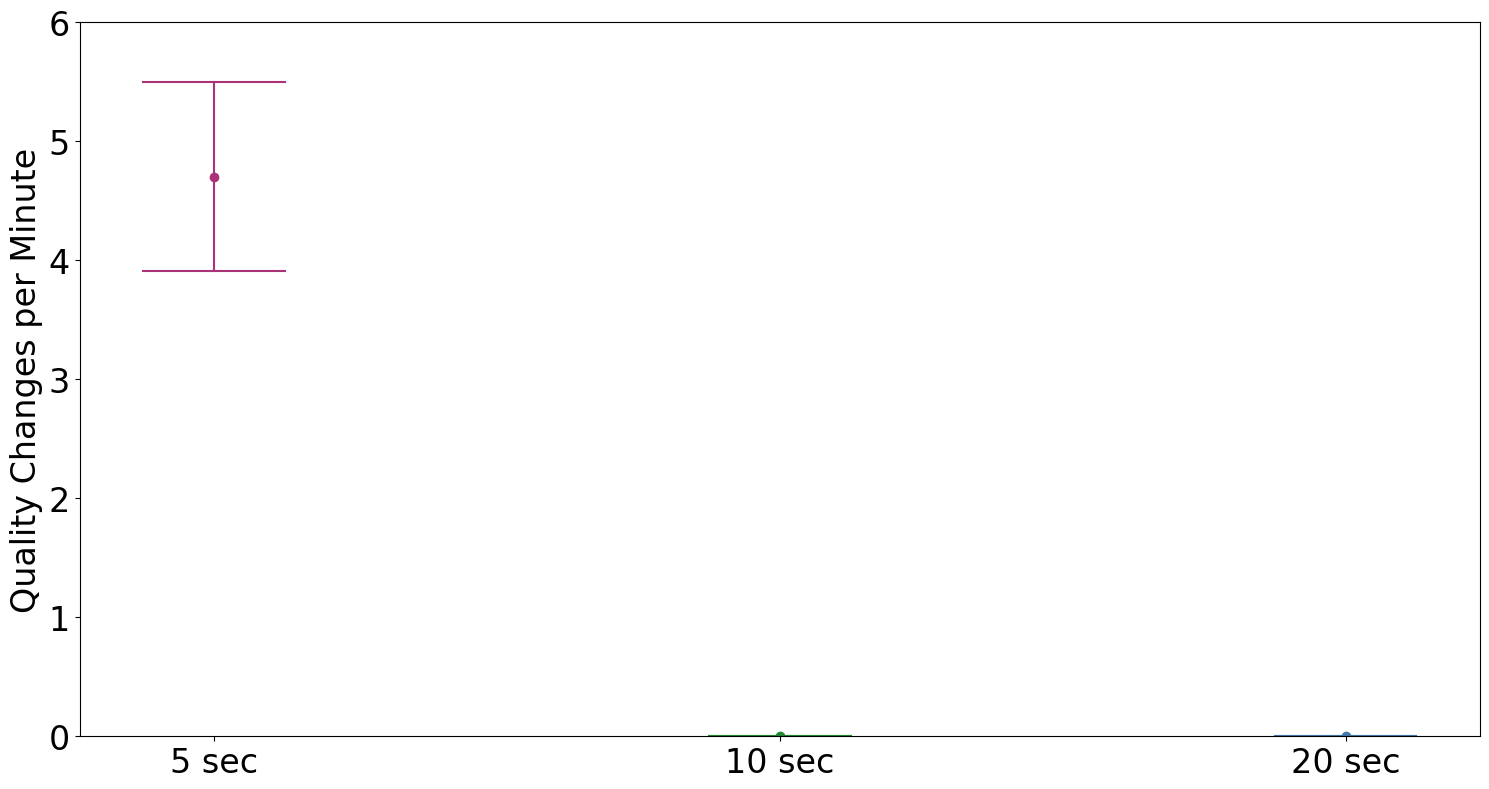

In [ ]:
import matplotlib.pyplot as plt

def plot_confidence_intervals(x, values, line_colors, dot_colors, index, horizontal_line_width=0.25):
    mean, margin_of_error, lower_bound, upper_bound = confidence_interval(values, 0.95)

    plt.ylim(0, 6)

    left = x - horizontal_line_width / 2
    top = lower_bound
    right = x + horizontal_line_width / 2
    bottom = upper_bound
    line_color = line_colors[index]
    dot_color = dot_colors[index]
    plt.plot([x, x], [top, bottom], color=line_color)
    plt.plot([left, right], [top, top], color=line_color)
    plt.plot([left, right], [bottom, bottom], color=line_color)
    plt.plot(x, mean, 'o', color=dot_color)

# line_colors = ['#4477AA', '#AA3377', '#228833']
# dot_colors = ['#4477AA', '#AA3377', '#228833']
line_colors = ['#AA3377', '#228833', '#4477AA']
dot_colors = ['#AA3377', '#228833', '#4477AA']
plt.figure(figsize=(15, 8)) 
# plt.xticks([1, 2, 3], ['ABR Bola', 'ABR Dynamic', 'ABR Throughput'], fontsize=12)
plt.xticks([1, 2, 3], ['5 sec', '10 sec', '20 sec'], fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.ylabel('Quality Changes per Minute', fontsize=24)

plot_confidence_intervals(1, quality_chnages_bola, line_colors, dot_colors, 0)
plot_confidence_intervals(2, quality_chnages_dynamic, line_colors, dot_colors, 1)
plot_confidence_intervals(3, quality_chnages_thru, line_colors, dot_colors, 2)

plt.tight_layout() 
plt.savefig('confidence_interval_seg_len.svg', format='svg')  # Save the figure as an SVG file
plt.show()
